# Unt type sampling bias

author: steeve.laquitaine@epfl.ch  

**methods**:
* We focus on single-units
* multi-units have not one type by definition.

**conclusion**:
* **strong sampling bias**: single-unit excitatory cADpyr from L5,6 then L2/3 and 4 are preferentially captured by all spike sorters. INH units are strongly undersampled.
* All tested spike sorters share the same sampling bias.

**next**:
* what is effect of this sampling bias on the circuit's information capacity (IC)?
    * contrast IC b/w random sampling vs. biased sampling.

### Setup

Setup `manifold` env

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA # dimensionality reduction
from mftma.manifold_analysis_correlation import manifold_analysis_corr
import random
import seaborn as sns
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
from scipy.stats import kruskal  # stats
import scikit_posthocs as sp


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.code import igeom
from src.nodes.metrics.quality import get_scores
from src.nodes.analysis.features import features as feat

# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]


# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

2024-10-22 18:24:33,749 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-22 18:24:33,910 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def sort_count_by_layer_synapse(counts):
    counts["sort_col"] = counts["type"].T.apply(lambda row: row[:2])
    counts = counts.sort_values(by="sort_col")
    counts = counts.drop(columns=["sort_col"])
    return counts

## (40s)Load datasets

In [3]:
# get sorted unit quality and bias classification
quality_df = pd.read_csv(quality_path)

# get true evoked data
SortingTrue = si.load_extractor(GT)
Recording = si.load_extractor(REC)
duration_secs = Recording.get_total_duration()
SFREQ = SortingTrue.get_sampling_frequency()

# get SortingExtractors
SortingK4 = si.load_extractor(K4)
SortingK3 = si.load_extractor(K3)
SortingK25 = si.load_extractor(K25)
SortingK2 = si.load_extractor(K2)
SortingKS = si.load_extractor(KS)
SortingHS = si.load_extractor(HS)

In [4]:
# (15s) create dataset of sorted unit types (derived from their best matched ground truth)
df_k4 = feat.get_feature_data_for("KS4", SortingK4, SortingTrue, quality_path, DT)
df_k3 = feat.get_feature_data_for("KS3", SortingK3, SortingTrue, quality_path, DT)
df_k25 = feat.get_feature_data_for("KS2.5", SortingK25, SortingTrue, quality_path, DT)
df_k2 = feat.get_feature_data_for("KS2", SortingK2, SortingTrue, quality_path, DT)
df_ks = feat.get_feature_data_for("KS", SortingKS, SortingTrue, quality_path, DT)
df_hs = feat.get_feature_data_for("HS", SortingHS, SortingTrue, quality_path, DT)
df = pd.concat([df_k4, df_k3, df_k25, df_k2, df_ks, df_hs])

# count the number of occurrences of each unique unit types
# in ground truth
# choose three features to describe units
df_gt = feat.get_unit_features(SortingTrue)
unique_type_feat = ["layer", "synapse", "etype"]

# get unique unit types observed across the
# dataset
unique_type = df_gt.drop_duplicates()
unique_type = unique_type.sort_values(by=["layer", "synapse"])

### (40s)Unit type distribution

In [5]:
# count unit types by spike sorter
count_gt = feat.count_unit_type(
    df_gt[unique_type_feat],
    unique_type,
)
# count_gt = sort_count_by_layer_synapse(count_gt)
count_k4 = feat.count_unit_type(
    df_k4[unique_type_feat],
    unique_type,
)
count_k3 = feat.count_unit_type(
    df_k3[unique_type_feat],
    unique_type,
)
count_k25 = feat.count_unit_type(
    df_k25[unique_type_feat],
    unique_type,
)
count_k2 = feat.count_unit_type(
    df_k2[unique_type_feat],
    unique_type,
)
count_ks = feat.count_unit_type(
    df_ks[unique_type_feat],
    unique_type,
)
count_hs = feat.count_unit_type(
    df_hs[unique_type_feat],
    unique_type,
)
type_nm = count_gt
type_nm.head(5)

,type,count
0,"(L1, INH, cACint)",2
1,"(L1, INH, cNAC)",4
2,"(L2/3, EXC, cADpyr)",342
3,"(L2/3, INH, dNAC)",4
4,"(L2/3, INH, cNAC)",6


### Plot type dist. by sorter

* all unit types exist in the ground truth so it probability distribution has no zero values and we can calculate the ratio between the biased distribution and the ground truth distribution, **the odds**.

In [6]:
def get_odds(count_sorting, count_gt):
    p_gt = count_gt["count"].values / sum(count_gt["count"].values)
    p_s = count_sorting["count"].values / sum(count_sorting["count"].values)
    return p_s / p_gt

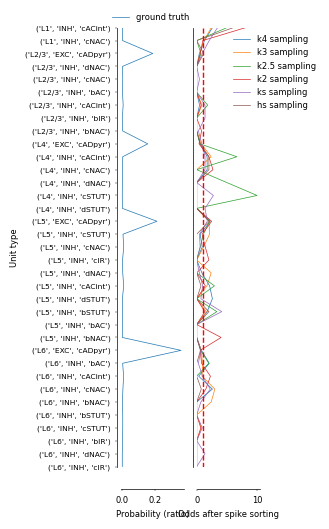

In [7]:
# setup plot
fig, ax = plt.subplots(1, 2, figsize=(1.8, 5.7))
xticks = np.arange(0, len(type_nm["type"]), 1)

# aesthetics
ax[0].plot(
    count_gt["count"].values / sum(count_gt["count"].values),
    xticks,
    label="ground truth",
)

# odds
ax[1].plot(
    get_odds(count_k4, count_gt),
    xticks,
    label="k4 sampling",
)
ax[1].plot(
    get_odds(count_k3, count_gt),
    xticks,
    label="k3 sampling",
)
ax[1].plot(
    get_odds(count_k25, count_gt),
    xticks,
    label="k2.5 sampling",
)
ax[1].plot(
    get_odds(count_k2, count_gt),
    xticks,
    label="k2 sampling",
)
ax[1].plot(
    get_odds(count_ks, count_gt),
    xticks,
    label="ks sampling",
)
ax[1].plot(
    get_odds(count_hs, count_gt),
    xticks,
    label="hs sampling",
)
ax[1].vlines(x=1, ymin=0, ymax=len(count_gt), color="r", linestyle="--", linewidth=1)

# aesthetics

# disconnected axes
ax[0].set_xlim(left=-1e-2)
ax[0].set_ylim([0, len(count_gt) - 1])
ax[0].set_xlabel("Ground truths")
ax[0].spines["bottom"].set_position(("axes", -0.05))
ax[0].spines["left"].set_position(("axes", -0.05))
# legend
ax[0].set_ylabel("Proportion (ratio)")
ax[0].set_yticks(xticks, type_nm["type"], rotation=0, fontsize=5.4)
ax[0].set_ylabel("Unit type")
ax[0].set_xlabel("Probability (ratio)")
ax[0].legend(frameon=False, loc="upper right", bbox_to_anchor=(1.2, 1.05))
ax[0].invert_yaxis()


ax[1].set_xlim(left=-1e-2)
ax[1].set_ylim([0, len(count_gt) - 1])
ax[1].set_xlabel("Ground truths")
ax[1].spines["bottom"].set_position(("axes", -0.05))
ax[1].spines["left"].set_position(("axes", -0.05))
ax[1].set_yticks([])
ax[1].set_xlabel("Odds after spike sorting")
ax[1].legend(frameon=False, loc="upper right", bbox_to_anchor=(2, 1))
ax[1].invert_yaxis()

# save
utils.savefig(
    PROJ_PATH + "/figures/2_biases/assets/fig6G_sampling_bias.svg",
)

In [8]:
def get_sampling_bias_matrix(sorter, bias_df, count_sorting, count_gt, thresh):
    bias_df["type"] = count_gt["type"]
    bias_df[sorter] = 0
    bias_df.loc[np.where(get_odds(count_sorting, count_gt) >= thresh)[0], sorter] = 1
    bias_df.loc[
        np.where(get_odds(count_sorting, count_gt) <= 1 / thresh)[0], sorter
    ] = -1
    return bias_df

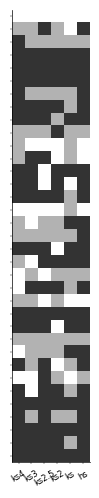

In [23]:
# plot
fig, ax = plt.subplots(figsize=(1, 10))

BIAS_THRESH = 2

bias_df = pd.DataFrame()
bias_df = get_sampling_bias_matrix(
    "ks4", bias_df, count_k4, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks3", bias_df, count_k3, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2.5", bias_df, count_k25, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2", bias_df, count_k2, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks", bias_df, count_ks, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "hs", bias_df, count_hs, count_gt, thresh=BIAS_THRESH
)
sorters = ["ks4", "ks3", "ks2.5", "ks2", "ks", "hs"]

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([[0.2, 0.2, 0.2], (0.7, 0.7, 0.7), (1, 1, 1)])

ax.imshow(
    bias_df[sorters].values,
    aspect=1,
    cmap=cmap,
    rasterized=True,  # memory efficiency
)
ax.set_xticks(np.arange(0, len(sorters), 1), sorters)
# ax.set_yticks(np.arange(0, len(count_gt), 1), count_gt["type"], fontsize=5.4)
plt.xticks(rotation=30)
ax.set_yticks(np.arange(0, len(count_gt), 1), [])

# save
utils.savefig_with_params(
    PROJ_PATH + "/figures/2_biases/assets/fig6H_sampling_bias_mx.svg",
    dpi=300,
    transparent=True,
)

utils.savefig_with_params(
    PROJ_PATH + "/figures/2_biases/assets/fig6H_sampling_bias_mx.png",
    dpi=300,
    transparent=True,
)

### Plot unit types by quality

In [18]:
# parameters
df_all = [df_k4, df_k3, df_k25, df_k2, df_ks, df_hs]
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# compute unit type distribution by spike sorter
count_g, count_oo = feat.count_unit_type_by_quality(
    df_all, sorters, unique_type_feat, unique_type
)

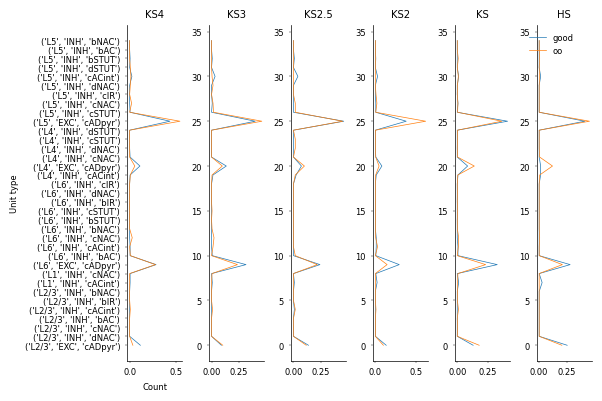

In [19]:
# plot raw count
fig, ax = plt.subplots(1, len(count_g.keys()), figsize=(6, 4))

# loop over spike sorter
for ix in range(len(count_g.keys())):

    ticks = np.arange(0, len(type_nm), 1)

    # aesthetics
    if ix == 0:
        ax[ix].set_yticks(xticks, type_nm["type"], rotation=0)
        ax[ix].set_xlabel("Count")
        ax[ix].set_ylabel("Unit type")

    # proportions
    # mixed: good
    ax[ix].plot(
        count_g[sorters[ix]]["count"].values
        / sum(count_g[sorters[ix]]["count"].values),
        xticks,
        label="good",
    )

    # poor: overmerger + oversplitter
    ax[ix].plot(
        count_oo[sorters[ix]]["count"].values
        / sum(count_oo[sorters[ix]]["count"].values),
        xticks,
        label="oo",
    )
    if ix == len(count_g.keys()) - 1:
        ax[ix].legend(frameon=False, loc="upper right", bbox_to_anchor=(0.8, 1))
    ax[ix].set_title(sorters[ix])

plt.tight_layout()